In [1]:
#imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_auc_score, f1_score

2024-09-01 10:32:30.928948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 10:32:32.032904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def csv_to_numpy_with_names(filename: str):
    data = np.genfromtxt(filename, delimiter=',', dtype=np.float64, names=True)
    names = data.dtype.names
    array = data.view((data.dtype[0], len(data.dtype.names)))
    return array, names

In [3]:
#get data from .csv file
train_data, names = csv_to_numpy_with_names("./dataset/exoTrain.csv")
test_data = csv_to_numpy_with_names("./dataset/exoTest.csv")[0]

In [4]:
#data info
print("Column names:")
print(names)
print()
print("=====================================================================================================================")
print()
print("Data:")
print(train_data)
print()
print("=====================================================================================================================")
print()
print("Train shape:")
print(train_data.shape)
print()
print("Test shape:")
print(test_data.shape)

Column names:
('LABEL', 'FLUX1', 'FLUX2', 'FLUX3', 'FLUX4', 'FLUX5', 'FLUX6', 'FLUX7', 'FLUX8', 'FLUX9', 'FLUX10', 'FLUX11', 'FLUX12', 'FLUX13', 'FLUX14', 'FLUX15', 'FLUX16', 'FLUX17', 'FLUX18', 'FLUX19', 'FLUX20', 'FLUX21', 'FLUX22', 'FLUX23', 'FLUX24', 'FLUX25', 'FLUX26', 'FLUX27', 'FLUX28', 'FLUX29', 'FLUX30', 'FLUX31', 'FLUX32', 'FLUX33', 'FLUX34', 'FLUX35', 'FLUX36', 'FLUX37', 'FLUX38', 'FLUX39', 'FLUX40', 'FLUX41', 'FLUX42', 'FLUX43', 'FLUX44', 'FLUX45', 'FLUX46', 'FLUX47', 'FLUX48', 'FLUX49', 'FLUX50', 'FLUX51', 'FLUX52', 'FLUX53', 'FLUX54', 'FLUX55', 'FLUX56', 'FLUX57', 'FLUX58', 'FLUX59', 'FLUX60', 'FLUX61', 'FLUX62', 'FLUX63', 'FLUX64', 'FLUX65', 'FLUX66', 'FLUX67', 'FLUX68', 'FLUX69', 'FLUX70', 'FLUX71', 'FLUX72', 'FLUX73', 'FLUX74', 'FLUX75', 'FLUX76', 'FLUX77', 'FLUX78', 'FLUX79', 'FLUX80', 'FLUX81', 'FLUX82', 'FLUX83', 'FLUX84', 'FLUX85', 'FLUX86', 'FLUX87', 'FLUX88', 'FLUX89', 'FLUX90', 'FLUX91', 'FLUX92', 'FLUX93', 'FLUX94', 'FLUX95', 'FLUX96', 'FLUX97', 'FLUX98', 'FLUX

In [5]:
#get labels
X_train, y_train = np.delete(train_data, 0, axis=1), np.take(train_data, 0, axis=1).astype(int)
X_test, y_test = np.delete(test_data, 0, axis=1), np.take(test_data, 0, axis=1).astype(int)

In [6]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is.... :c

(array([1, 2]), array([5050,   37]))


In [7]:
#indexes of data classes
planet_indexes = np.where(y_train == 2)[0]
no_planet_indexes = np.where(y_train == 1)[0]

print("Planet indexes:", planet_indexes)

Planet indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [8]:
#undersampling
n_under = 2500
X_under = np.array([X_train[ind] for ind in np.random.choice(no_planet_indexes, n_under, replace=False)])
y_under = np.array([y_train[ind] for ind in np.random.choice(no_planet_indexes, n_under, replace=False)])

In [9]:
#oversampling
n_over = 2500
X_over = np.array([X_train[ind] for ind in np.random.choice(planet_indexes, n_over, replace=True)])
y_over = np.array([2 for _ in range(n_over)])

In [10]:
#concatenate undersampled data with oversampled data
X_train, y_train = np.concatenate((X_under, X_over)), np.concatenate((y_under, y_over))

In [11]:
#shuffle new datasets
permutation = np.random.permutation(len(y_train))
X_train, y_train = X_train[permutation], y_train[permutation]

In [12]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is not c:

(array([1, 2]), array([2500, 2500]))


In [13]:
def show_charts(X, y, indexes, show_labels=False):
    fig, axes = plt.subplots(1, len(indexes), figsize=(20, 5)) 
    for i in range(len(indexes)):
        index = indexes[i]
        axes[i].plot(X[index])
        axes[i].set_title(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
        # print(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
    plt.show()

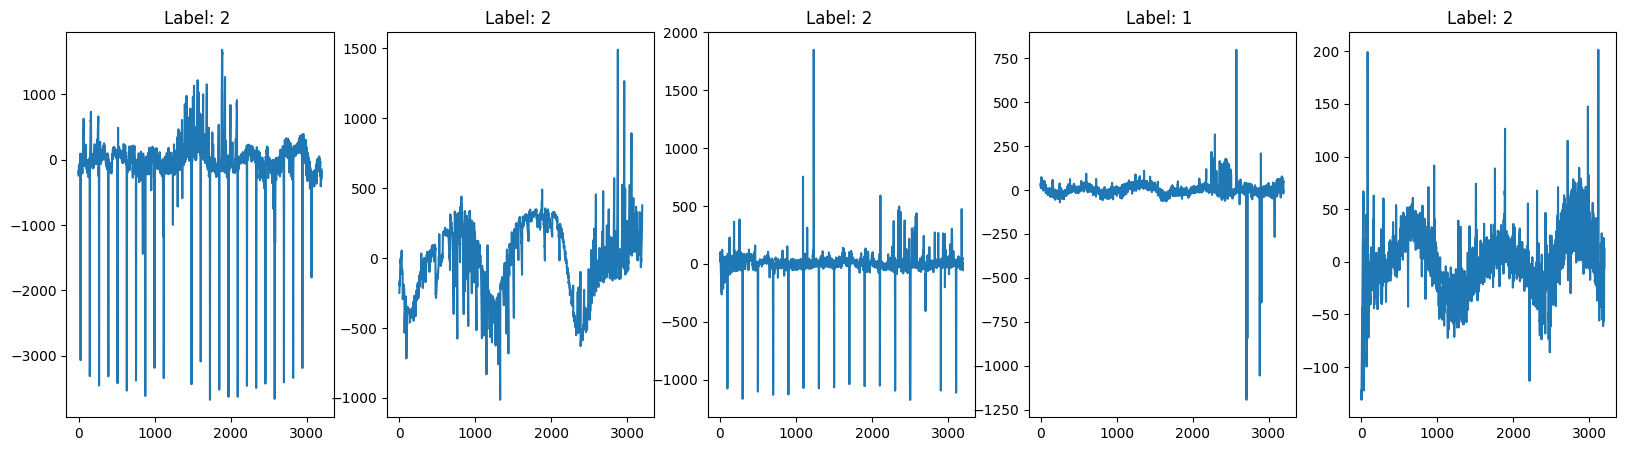

In [14]:
#charts
chart_indexes = [np.random.randint(0, 5000) for _ in range(5)]
show_charts(X_train, y_train, chart_indexes)

In [15]:
def remove_outliers(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        q1 = np.percentile(X_data[i], 25)
        q3 = np.percentile(X_data[i], 75)
        iqr = q3 - q1

        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr

        for j in range(1, len(X_data[i])-1):
            if X_data[i][j] < min_val or X_data[i][j] > max_val:
                # X[i][j] = (X_data[i][j-1] + X_data[i][j+1]) / 2
                X[i][j] = X_data[i][j-1]
            else:
                X[i][j] = X_data[i][j]
    return X
    
def normalize_01(data):
    min_val = min(data)
    max_val = max(data)
    d = max_val - min_val
    return (data - min_val) / d

def normalize_X_01(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        X[i] = normalize_01(X_data[i])
    return X

def prepare_X_data(X_data):
    X = remove_outliers(X_data)
    X = normalize_X_01(X)
    return X
    

In [16]:
#preparing data
X_train, y_train = prepare_X_data(X_train), normalize_01(y_train).astype(int)
X_test, y_test = prepare_X_data(X_test), normalize_01(y_test).astype(int)

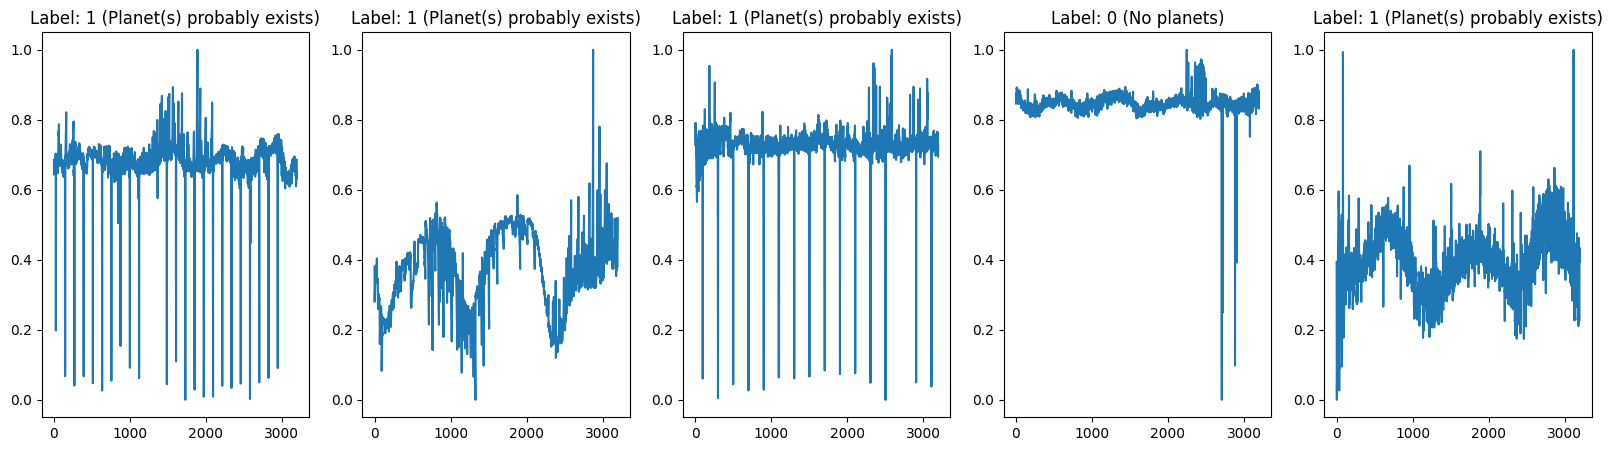

In [17]:
#charts
show_charts(X_train, y_train, chart_indexes, show_labels=True)

In [18]:
#define model
n1 = 1500
n2 = 700
n3 = 200

model = Sequential()
model.add(Dense(n1, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(n2, activation='tanh'))
model.add(Dense(n3, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

2024-09-01 10:33:21.251191: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/filipjedrzejewski/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
#model compilation
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
             metrics=[AUC(), 'accuracy'])

In [20]:
#training
model.fit(X_train, y_train, epochs=5, batch_size=50)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 2814s 28s/step - accuracy: 0.5015 - auc: 0.5073 - loss: 0.6116
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 2832s 28s/step - accuracy: 0.5076 - auc: 0.5097 - loss: 0.1969
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 2872s 29s/step - accuracy: 0.4959 - auc: 0.5022 - loss: 0.1863
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 2836s 28s/step - accuracy: 0.4942 - auc: 0.4955 - loss: 0.1807
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 2798s 28s/step - accuracy: 0.4928 - auc: 0.4884 - loss: 0.1790


In [21]:
#increase test data size - oversampling - for better test quality
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([565,   5]))


In [22]:
n_over = 550
planet_test_indexes = planet_indexes = np.where(y_test == 1)[0]
X_test_over = np.array([X_test[ind] for ind in np.random.choice(planet_test_indexes, n_over)])
y_test_over = np.array([1 for _ in range(n_over)])

In [23]:
X_test, y_test = np.concatenate((X_test, X_test_over)), np.concatenate((y_test, y_test_over))

In [24]:
#tests
loss, accuracy, auc = model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("AUC:", auc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 311s 9s/step - accuracy: 0.1818 - auc: 0.5000 - loss: 0.2989
Loss: 0.21334309875965118
Accuracy: 0.4955357015132904
AUC: 0.5


In [25]:
y_pred = model.predict(X_test)
classes_pred = np.array([1 if prediction >= 0.5 else 0 for prediction in y_pred])

print(classes_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step
[1 1 1 ... 1 1 1]


In [26]:
#confusion matrix
con_matrix = tf.math.confusion_matrix(labels=y_test, predictions=classes_pred)
print(con_matrix)

tf.Tensor(
[[  0 565]
 [  0 555]], shape=(2, 2), dtype=int32)


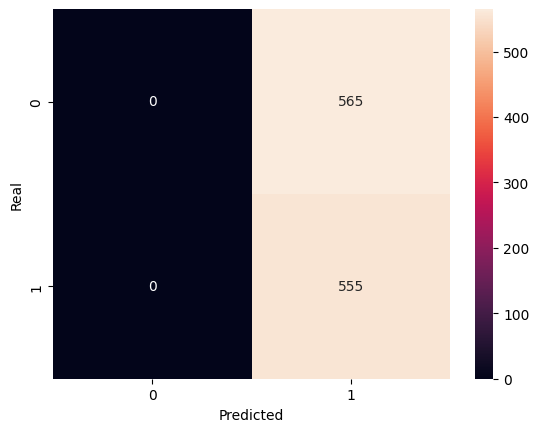

In [27]:
#show confusion matrix
plt.figure()
sns.heatmap(con_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

In [28]:
#AUC
auc = roc_auc_score(y_test, classes_pred)
print("AUC:", auc)

AUC: 0.5


In [29]:
#F1
f1 = f1_score(y_test, classes_pred)
print("F1:", f1)

F1: 0.6626865671641791
